In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import Union

from langchain.schema import Document
from langchain.prompts import PromptTemplate
from langchain_core.vectorstores import VectorStoreRetriever
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain_neo4j import Neo4jVector, GraphCypherQAChain, Neo4jGraph
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

from ragas.dataset_schema import EvaluationResult
from ragas import EvaluationDataset
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import (
    SemanticSimilarity,
    AnswerRelevancy, 
    Faithfulness, 
    FactualCorrectness, 
    AnswerCorrectness, 
    LLMContextRecall, 
    ContextRecall, 
    ContextPrecision, 
)

metrics_list = [
    Faithfulness(),
    AnswerRelevancy(),
    SemanticSimilarity(),
    
]

np.random.seed(42)

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### TO-DO
1. Track running time

In [68]:
# TODO: edit configuration
# Eval setting
SUBSET_SIZE = -1
EVAL_CACHE_DIR = "eval-semantic-human-qa-easy/"
# EVAL_CACHE_DIR = "eval-vector-auto-qa/"

USE_CACHE = True
GRAPH_RETRIEVAL_METHOD = "semantic"  # semantic or vector
EVAL_SET = [
    # "VectorRAG_Baseline", 
    # "Microsoft_GraphRAG_1",
    # "Microsoft_GraphRAG_2",
    # "LLMGraphTransformer_GraphRAG_1",
    # "LLMGraphTransformer_GraphRAG_2",
    # "OpenAI_GraphRAG",
    "Llama_Index_GraphRAG",
]

RETRIEVER_CONFIG = {
    k: None for k in EVAL_SET
}

# General RAG setting
TOP_K = 3

# Vector RAG setting
CHUNK_SIZE = 512
CHUNK_OVERLAP = 32

In [69]:
# load environment variables
from dotenv import load_dotenv
load_dotenv("./config/private-config.env")

True

In [70]:
def empty_cache():
    os.remove(EVAL_CACHE_DIR, ignore_errors=True)
    os.remove(os.environ["CHROMA_DB"], ignore_errors=True)
    os.remove(os.environ["QR_DATA"], ignore_errors=True)

if not USE_CACHE:
    empty_cache()

### LLM Config

In [71]:
# Embedding model
embed = OpenAIEmbeddings()

# LLM model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

### QR Dataset Preparation

In [72]:
def prepare_product_df() -> pd.DataFrame:
    """
    Load the Amazon product dataset and filter for beauty products.
    """
    df = pd.read_csv("./data/cosmetics_25_products.csv", index_col=0)
    df.columns = df.columns.str.lower()
    df["title"] = df["name"]
    return df


# def prepare_product_df():
#     # Read data from a text file
#     with open('data/message.txt', 'r', encoding='utf-8') as file:
#         data = file.read()

#     # Split into products by splitting on double newlines
#     products = data.strip().split('\n\n')

#     # Prepare list to hold each product's data
#     product_list = []

#     for product in products:
#         product_data = {}

#         # Extract each line that contains ':'
#         lines = product.split('\n')
#         for line in lines:
#             if ':' in line:
#                 key, value = line.split(':', 1)  # Split only at the first colon
#                 product_data[key.strip().lower()] = value.strip()

#         product_list.append(product_data)

#     # Convert list to DataFrame
#     return pd.DataFrame(product_list)

In [73]:
async def generate_qr_data(
        df: pd.DataFrame, 
        llm: ChatOpenAI,
        metadata_fields: list = ["description", "title"],
        num_questions_per_chunk: int = 1,
    ) -> pd.DataFrame:
    """
    Generate QR data for the given DataFrame.
    """
    from llama_index.core import Document
    from llama_index.core.evaluation import DatasetGenerator
    cols = df.columns

    docs = []
    for i, row in df.iterrows():
        doctext = [f"{col}: {row[col]}" for col in cols]
        doctext = "\n".join(doctext)
        doc = Document(
            text=doctext,
            metadata={field: row[field] for field in metadata_fields},
        )
        docs.append(doc)

    dataset_generator = DatasetGenerator.from_documents(
        docs,
        num_questions_per_chunk=num_questions_per_chunk,
        show_progress=True,
    )
    qr_ds = await dataset_generator.agenerate_dataset_from_nodes()
    qr_ds.save_json(os.environ["QR_DATA"])
    qr_ds = {
        "queries": qr_ds.queries,
        "responses": qr_ds.responses,
    }
    return qr_ds



In [74]:
# Load QA data
df = prepare_product_df()
if not os.path.exists(os.environ["QR_DATA"]):
    df = prepare_product_df()
    print(f"Loaded {len(df)} products")
    qr_data = await generate_qr_data(
        df,
        llm,
        metadata_fields=["description", "title"],
        num_questions_per_chunk=1,
    )
else:
    with open(os.environ["QR_DATA"], "r") as f:
        qr_data = json.load(f)

In [75]:
# load question-response dataset in json format for evaluation
questions = [q for q in qr_data['queries'].values()]
responses = [r for r in qr_data['responses'].values()]
size = len(questions)
idx = np.random.randint(0, size, SUBSET_SIZE) if SUBSET_SIZE > 0 else np.arange(size)
questions, responses = [questions[i] for i in idx], [responses[i] for i in idx]
len(questions), len(responses)

(78, 78)

### Vector RAG

In [76]:
def df2docs(df: pd.DataFrame) -> list[Document]:
    """
    Convert DataFrame to list of Documents.
    """
    docs = []
    for i, row in df.iterrows():
        doctext = [f"{col}: {row[col]}" for col in df.columns]
        doctext = "\n".join(doctext)
        doc = Document(
            page_content=doctext,
            metadata={col: row[col] for col in df.columns},
        )
        docs.append(doc)
    return docs


documents = df2docs(df)
# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
docstore = text_splitter.split_documents(documents)

# Create ChromaDB and store embeddings
db = Chroma.from_documents(docstore, embed, persist_directory="./chroma_db")

# Create a retriever
vecstore = db.as_retriever(search_kwargs={"k": TOP_K})

### GraphRAG - Vector Search

In [77]:
def get_graphstore(
        url: str, 
        username: str,
        password: str,
    ) -> Neo4jVector:
    """
    Create a Neo4j vector store.
    """
    graph_vecstore = Neo4jVector.from_existing_graph(
        embedding=embed,
        url=url,
        username=username,
        password=password,
        index_name="product_index",
        node_label="Product",
        text_node_properties=["description"],
        embedding_node_property="embedding",
    )
    return graph_vecstore

### GraphRAG - Semantic Search (Cypher)

In [78]:
def get_cypher_chain(
    llm: ChatOpenAI,
    url: str,
    username: str,
    password: str,
) -> GraphCypherQAChain:
    return GraphCypherQAChain.from_llm(
        llm=llm,
        graph=Neo4jGraph(
            url=url,
            username=username,
            password=password,
        ),
        verbose=True,
        enhanced_schema=True,
        allow_dangerous_requests=True,
        return_intermediate_steps=True,
    )

In [79]:
def cypher_retrieve(cypher_chain: GraphCypherQAChain, query: str) -> list[Document]:
    
    response = cypher_chain.invoke({"query": query})

    # cypher_query = Document(f"""
    # Cypher Query:
    # {response["intermediate_steps"][0]["query"]}
    # """)
    # schema = Document(f"""
    # Schema:
    # {cypher_chain.graph.schema}
    # """)
    relevant_docs = response["intermediate_steps"][1]["context"]
    relevant_docs = [Document(str(doc)) for doc in relevant_docs]
    answer = response["result"]
    return relevant_docs, answer

In [80]:
neo4j_config = json.load(open(os.environ["NEO4J_CONFIG"], 'r'))
for method in EVAL_SET:
    if method == "VectorRAG_Baseline":
        RETRIEVER_CONFIG[method] = vecstore
    elif "GraphRAG" in method:
        url = neo4j_config[method]["uri"]
        username = neo4j_config[method]["username"]
        password = neo4j_config[method]["password"]
        if GRAPH_RETRIEVAL_METHOD == "vector":
            graphstore = get_graphstore(url, username, password)
        elif GRAPH_RETRIEVAL_METHOD == "semantic":
            graphstore = get_cypher_chain(llm, url, username, password)
        else: 
            raise ValueError(f"Unknown graph retrieval method: {GRAPH_RETRIEVAL_METHOD}")
        RETRIEVER_CONFIG[method] = graphstore
    else:
        raise ValueError(f"Unknown method: {method}")

### Evaluation on Question Answering Task

In [81]:
def eval_qr_data(
        questions: list[str], 
        responses: list[str], 
        retriever: Union[VectorStoreRetriever, Neo4jVector, GraphCypherQAChain], 
        llm: ChatOpenAI,
    ) -> EvaluationDataset:
    """
    Wraps the evaluation data into a list of dictionaries.
    """
    dataset = []
    response = None

    for query, reference in tqdm(zip(questions, responses), total=len(questions)):

        if isinstance(retriever, VectorStoreRetriever):
            relevant_docs = retriever.invoke(query)
        elif isinstance(retriever, Neo4jVector):
            relevant_docs = retriever.similarity_search(query, k=TOP_K)
        elif isinstance(retriever, GraphCypherQAChain):
            try:
                relevant_docs, response = cypher_retrieve(retriever, query)
            # sometimes the cypher query fails, so we skip it
            except Exception as e:
                print(f"Cypher QA Chain failed, skipping query: {query}")
                continue
        else:
            raise ValueError("Unsupported retriever type")
        
        relevant_context = "\n".join([doc.page_content for doc in relevant_docs])
        prompt = f"""
        Based on the following context, answer the question:\n
        {relevant_context}\n
        Question: {query}\n
        Answer:
        """
        response = llm.invoke(prompt).content if response is None else response
        dataset.append(
            {
                "user_input":query,
                "retrieved_contexts":[d.page_content for d in relevant_docs],
                "response":response,
                "reference":reference
            }
        )

    return EvaluationDataset.from_list(dataset)

def eval(method: str, eval_llm: ChatOpenAI) -> EvaluationResult:
    retriever = RETRIEVER_CONFIG[method]
    print(f"Evaluating {method} ...")
    # Prepare the evaluation data
    eval_data = eval_qr_data(
        questions=questions,
        responses=responses,
        retriever=retriever,
        llm=llm,
    )
    # Eval
    eval_result = evaluate(
        dataset=eval_data,
        metrics=metrics_list,
        llm=eval_llm,
    )
    # Save the evaluation result
    eval_result.to_pandas().to_csv(
        os.path.join(EVAL_CACHE_DIR, f"{method}.csv"),
    )
    return eval_result

In [82]:
def parse_eval_results(
        eval_result: Union[EvaluationResult, pd.DataFrame], 
        method_name: str,
    ) -> pd.DataFrame:
    """
    Parses the evaluation results into a DataFrame.
    """
    if isinstance(eval_result, EvaluationResult):
        # Convert the evaluation result to a DataFrame
        eval_df = eval_result.to_pandas()
        metrics_names = [i for i in eval_result.scores[0].keys()]
    else:
        # If it's already a DataFrame, use it directly
        eval_df = eval_result
        metrics_names = [col for col in eval_result.columns if col not in ["user_input", "retrieved_contexts", "response", "reference"]]
    eval_df_long = pd.melt(
        eval_df,
        value_vars=metrics_names,  # Columns to unpivot
        var_name='metric',             # Name for the variable column
        value_name='score'              # Name for the value column
    )
    eval_df_long['method'] = method_name
    return eval_df_long

In [83]:
evaluator_llm = LangchainLLMWrapper(llm)

In [84]:
eval_df = pd.DataFrame()
if not os.path.exists(EVAL_CACHE_DIR):
    os.makedirs(EVAL_CACHE_DIR)
for method in EVAL_SET:
    if os.path.exists(os.path.join(EVAL_CACHE_DIR, f"{method}.csv")):
        print(f"Loading result of {method} ...")
        eval_result = pd.read_csv(os.path.join(EVAL_CACHE_DIR, f"{method}.csv"), index_col=0)
    else:
        eval_result = eval(method, evaluator_llm)
    df = parse_eval_results(eval_result, method)
    eval_df = pd.concat([eval_df, df], ignore_index=True)
eval_df.shape

Evaluating Llama_Index_GraphRAG ...


  0%|          | 0/78 [00:00<?, ?it/s]



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Facial Treatment Essence'})-[:CONTAINS]->(i:Ingredient)
RETURN p, i

Full Context:
[{'p': {'triplet_source_id': '104820f7-9218-4d57-a1fe-3116ff70d0de', 'entity_description': 'A moisturizer from SK-II, priced at $179, rated 4.1. It contains ingredients like Galactomyces Ferment Filtrate (Pitera), Butylene Glycol, Pentylene Glycol, Water, Sodium Benzoate, Methylparaben, Sorbic Acid. It promotes skin cell renewal, reduces wrinkles, refines texture, and improves radiance.', 'product_type': 'Moisturizer', 'price': '179', 'name': 'Facial Treatment Essence', 'rank': '4.1', 'id': 'Facial Treatment Essence', 'embedding': [-0.007816911675035954, -0.009958155453205109, 0.008290455676615238, -0.012044494971632957, -0.0023608582559973, -0.0013751656515523791, -0.006629619747400284, -0.016004422679543495, -0.01774761453270912, -0.017294660210609436, 0.0009325047140009701, 0.017720162868499756, -0.036840371

  1%|▏         | 1/78 [00:06<08:34,  6.68s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'The Moisturizing Soft Cream'})-[:MENTIONS]->(n:__Node__)
RETURN n.text AS benefits

Full Context:
[]


  3%|▎         | 2/78 [00:08<04:28,  3.54s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "GenOptics Aura Essence Serum"})-[:CONTAINS]->(i:Ingredient)
RETURN p, i

Full Context:
[{'p': {'triplet_source_id': '68e637fb-6744-462a-90ef-74c7c71ca3a5', 'entity_description': "A moisturizer priced at $240, rated 4.1, suitable for Dry, Normal, Oily, and Sensitive skin types. It targets dark spots and dullness, infused with SK-II's signature Pitera to help reduce the appearance of melanin and promote a more radiant, even-toned complexion.", 'product_type': 'Moisturizer', 'price': '240', 'name': 'GenOptics Aura Essence Serum', 'rank': '4.1', 'id': 'GenOptics Aura Essence Serum', 'embedding': [0.005570797249674797, -0.016536766663193703, -0.005440835375338793, -0.014078029431402683, 0.014309853315353394, 0.016452467069029808, -0.007874985225498676, -0.023449331521987915, -0.03903070464730263, -0.03723231330513954, 0.0005483863060362637, 0.0033017334062606096, -0.032146237790

  4%|▍         | 3/78 [00:20<09:48,  7.85s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'SK-II Facial Treatment Essence Mini'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name

Full Context:
[]


  5%|▌         | 4/78 [00:22<06:34,  5.34s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Facial Treatment Essence Mini'})-[:SUITABLE_FOR]->(s:SkinType)
RETURN s.name

Full Context:
[{'s.name': 'Dry Skin'}, {'s.name': 'Normal Skin'}, {'s.name': 'Oily Skin'}, {'s.name': 'Sensitive Skin'}]


  6%|▋         | 5/78 [00:24<04:57,  4.07s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product)-[:CONTAINS]->(i:Ingredient)
WHERE p.name CONTAINS 'essence' AND i.name CONTAINS 'travel-sized'
RETURN i.size

Full Context:
[]


  8%|▊         | 6/78 [00:25<03:51,  3.21s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p1:Product {name: 'Facial Treatment Essence Mini'})-[:MANUFACTURED_BY]->(b:Brand),
      (p2:Product {name: 'Facial Treatment Essence Full Size'})-[:MANUFACTURED_BY]->(b)
RETURN p1.price AS MiniPrice, p2.price AS FullSizePrice

Full Context:
[]


  9%|▉         | 7/78 [00:27<03:16,  2.77s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'SK-II Facial Treatment Essence Mini'})-[:MENTIONS]->(n)
RETURN n

Full Context:
[]


 10%|█         | 8/78 [00:29<02:48,  2.40s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'The Moisturizing Cool Gel Cream', brand: 'LA MER'})-[:SUITABLE_FOR]->(st:SkinType)
RETURN p.name, st.name

Full Context:
[]


 12%|█▏        | 9/78 [00:31<02:31,  2.19s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Oil-Free Gel-Cream'})-[:CONTAINS]->(i:Ingredient)
RETURN p.name, i.name

Full Context:
[{'p.name': 'Ultra Facial Oil-Free Gel-Cream', 'i.name': 'Water'}, {'p.name': 'Ultra Facial Oil-Free Gel-Cream', 'i.name': 'Glycerin'}]


 13%|█▎        | 10/78 [00:33<02:29,  2.20s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Oil-Free Gel-Cream'})-[:SUITABLE_FOR]->(s:SkinType)
RETURN s.name

Full Context:
[{'s.name': 'Normal Skin'}]


 14%|█▍        | 11/78 [00:34<02:12,  1.98s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Oil-Free Gel-Cream'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name AS main_ingredient

Full Context:
[{'main_ingredient': 'Water'}, {'main_ingredient': 'Glycerin'}]


 15%|█▌        | 12/78 [00:36<02:08,  1.94s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Ultra Facial Oil-Free Gel-Cream"})-[:MENTIONS]->(n:__Node__)
RETURN n.text AS hydration_duration

Full Context:
[]


 17%|█▋        | 13/78 [00:38<02:03,  1.90s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Oil-Free Gel-Cream'}) RETURN p.size

Full Context:
[{'p.size': None}]


 18%|█▊        | 14/78 [00:39<01:46,  1.66s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "The Moisturizing Soft Lotion"})-[:CONTAINS]->(i:Ingredient)
RETURN i.name

Full Context:
[]


 19%|█▉        | 15/78 [00:40<01:39,  1.58s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'The Moisturizing Soft Lotion'})-[:SUITABLE_FOR]->(s:SkinType)
RETURN s.name

Full Context:
[]


 21%|██        | 16/78 [00:42<01:37,  1.57s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'The Moisturizing Soft Lotion'})-[:MENTIONS]->(n:__Node__)
RETURN n.text AS texture_description

Full Context:
[]


 22%|██▏       | 17/78 [00:44<01:42,  1.68s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'The Moisturizing Soft Lotion'})-[:CONTAINS]->(i:Ingredient)
RETURN i.size AS container_size

Full Context:
[]


 23%|██▎       | 18/78 [00:45<01:35,  1.59s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "The Moisturizing Soft Lotion"})-[:CONTAINS]->(i:Ingredient {name: "miracle broth"})
RETURN p, i

Full Context:
[]


 24%|██▍       | 19/78 [00:47<01:32,  1.57s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Resilience Lift Night Lifting/Firming Face and Neck Creme"})-[:MENTIONS]->(n:__Node__)
RETURN n.text

Full Context:
[]


 26%|██▌       | 20/78 [00:48<01:32,  1.60s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Moisturizer', brand: 'KIEHL\'S SINCE 1851'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name

Full Context:
[{'i.name': 'Glycerin'}, {'i.name': 'Water Squalane'}]


 27%|██▋       | 21/78 [00:51<01:40,  1.76s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Moisturizer'})-[:SUITABLE_FOR]->(s:SkinType)
RETURN s.name

Full Context:
[{'s.name': 'Dry Skin'}, {'s.name': 'Normal Skin'}, {'s.name': 'Oily Skin'}, {'s.name': 'Sensitive Skin'}]


 28%|██▊       | 22/78 [00:52<01:34,  1.68s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Moisturizer'}) RETURN p.size

Full Context:
[{'p.size': None}]


 29%|██▉       | 23/78 [00:53<01:27,  1.58s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Moisturizer'})-[:CONTAINS]->(i:Ingredient)
RETURN p.name, i.name

Full Context:
[{'p.name': 'Ultra Facial Moisturizer', 'i.name': 'Glycerin'}, {'p.name': 'Ultra Facial Moisturizer', 'i.name': 'Water Squalane'}]


 31%|███       | 24/78 [00:55<01:30,  1.67s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Moisturizer'}) RETURN p.price

Full Context:
[{'p.price': '29'}]


 32%|███▏      | 25/78 [00:57<01:23,  1.57s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Advanced Night Repair Intensive Recovery Ampoules"})-[:MENTIONS]->(n:__Node__)
RETURN n

Full Context:
[]


 33%|███▎      | 26/78 [00:58<01:18,  1.51s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Revitalizing Supreme+ Global Anti-Aging Cell Power Creme SPF 15"})-[:CONTAINS]->(i:Ingredient)
RETURN p, i

Full Context:
[]


 35%|███▍      | 27/78 [01:00<01:25,  1.67s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Cream SPF 30'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name, i.price, i.brand, i.rank, i.skin_type

Full Context:
[{'i.name': 'Water', 'i.price': '150', 'i.brand': 'LA MER', 'i.rank': '4.1', 'i.skin_type': "['Dry', 'Normal', 'Oily', 'Sensitive']"}, {'i.name': 'Glycerin', 'i.price': '150', 'i.brand': 'LA MER', 'i.rank': '4.1', 'i.skin_type': "['Dry', 'Normal', 'Oily', 'Sensitive']"}]


 36%|███▌      | 28/78 [01:02<01:23,  1.67s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Cream SPF 30'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name

Full Context:
[{'i.name': 'Water'}, {'i.name': 'Glycerin'}]


 37%|███▋      | 29/78 [01:03<01:21,  1.67s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Cream SPF 30'})-[:MENTIONS]->(n:__Node__)
RETURN n.text

Full Context:
[]


 38%|███▊      | 30/78 [01:05<01:19,  1.66s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Cream SPF 30'})-[:SUITABLE_FOR]->(s:SkinType)
RETURN s.name

Full Context:
[{'s.name': 'Dry Skin'}, {'s.name': 'Normal Skin'}, {'s.name': 'Oily Skin'}, {'s.name': 'Sensitive Skin'}]


 40%|███▉      | 31/78 [01:07<01:26,  1.85s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ultra Facial Cream SPF 30'}) RETURN p.size

Full Context:
[{'p.size': None}]


 41%|████      | 32/78 [01:09<01:17,  1.68s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (product:Product {name: "SK-II Facial Treatment Mask"})-[:MENTIONS]->(benefit:__Node__)
RETURN benefit.text

Full Context:
[]


 42%|████▏     | 33/78 [01:10<01:11,  1.59s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (product:Product {name: 'Overnight Miracle Mask'})-[:MENTIONS]->(ingredient:Ingredient)
RETURN product, ingredient

Full Context:
[]


 44%|████▎     | 34/78 [01:11<01:06,  1.52s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Overnight Miracle Mask'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name

Full Context:
[{'i.name': 'Galactomyces Ferment Filtrate'}]


 45%|████▍     | 35/78 [01:14<01:21,  1.89s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Overnight Miracle Mask'})-[:SUITABLE_FOR]->(s:SkinType)
RETURN s.name

Full Context:
[{'s.name': 'Dry Skin'}, {'s.name': 'Normal Skin'}, {'s.name': 'Oily Skin'}, {'s.name': 'Sensitive Skin'}]


 46%|████▌     | 36/78 [01:16<01:17,  1.85s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Overnight Miracle Mask'}) RETURN p.size

Full Context:
[{'p.size': None}]


 47%|████▋     | 37/78 [01:17<01:12,  1.78s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Overnight Miracle Mask'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name LIMIT 1

Full Context:
[{'i.name': 'Galactomyces Ferment Filtrate'}]


 49%|████▊     | 38/78 [01:19<01:08,  1.71s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Calendula & Aloe Soothing Hydration Mask', brand: 'KIEHL\'S SINCE 1851'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name

Full Context:
[{'i.name': 'Aloe Barbadensis Leaf Juice'}]


 50%|█████     | 39/78 [01:21<01:09,  1.78s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Calendula & Aloe Soothing Hydration Mask'})-[:SUITABLE_FOR]->(s:SkinType)
RETURN s.name

Full Context:
[{'s.name': 'Dry'}, {'s.name': 'Normal'}, {'s.name': 'Oily'}, {'s.name': 'Sensitive'}]


 51%|█████▏    | 40/78 [01:23<01:06,  1.74s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Calendula & Aloe Soothing Hydration Mask"})-[:CONTAINS]->(i:Ingredient)
RETURN p, i

Full Context:
[{'p': {'triplet_source_id': '0c22868b-6d52-43ad-8ea4-356081fedeb6', 'entity_description': "A Face Mask from KIEHL'S SINCE 1851, priced at $45, rated 4.0. It contains ingredients like Water, Glycerin, Aloe Barbadensis Leaf Juice, and others. It provides immediate soothing hydration for dry, sensitive or irritated skin, leaving it feeling calm and replenished.", 'product_type': 'Face Mask', 'price': '45', 'name': 'Calendula & Aloe Soothing Hydration Mask', 'rank': '4.0', 'id': 'Calendula & Aloe Soothing Hydration Mask', 'embedding': [0.0008398512145504355, 0.012384621426463127, 0.015353397466242313, -0.022065414115786552, -0.003074076259508729, 0.010061231441795826, -0.013159085065126419, -6.700658559566364e-06, -0.017690375447273254, -0.026032840833067894, 0.02119584195315838,

 53%|█████▎    | 41/78 [01:33<02:40,  4.33s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Calendula & Aloe Soothing Hydration Mask'}) 
RETURN p.size

Full Context:
[{'p.size': None}]


 54%|█████▍    | 42/78 [01:35<02:05,  3.49s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product)-[:CONTAINS]->(i:Ingredient)
WHERE i.name IN ['calendula flower petals', 'aloe vera']
RETURN p.name, p.entity_description

Full Context:
[]


 55%|█████▌    | 43/78 [01:37<01:55,  3.31s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "SK-II Brightening Derm Revival Mask"})-[:CONTAINS]->(i:Ingredient)
RETURN i.name, i.entity_description

Full Context:
[]


 56%|█████▋    | 44/78 [01:39<01:33,  2.74s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ginger Leaf & Hibiscus Firming Mask'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name

Full Context:
[{'i.name': 'Ginger Leaf'}, {'i.name': 'Hibiscus Seed Extract'}]


 58%|█████▊    | 45/78 [01:41<01:20,  2.45s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Ginger Leaf & Hibiscus Firming Mask"})-[:CONTAINS]->(i:Ingredient)
RETURN p, i

Full Context:
[{'p': {'triplet_source_id': '34ea2dd5-f8dd-4a23-97b0-6c7667b689fc', 'entity_description': "A face mask priced at $54, rated 4.4, suitable for dry, normal, oily, and sensitive skin types. It contains ingredients like water, PVP, propanediol, and others. It is formulated with ginger leaf and hibiscus seed extract to help visibly improve skin's elasticity and reduce the appearance of fine lines and wrinkles.", 'product_type': 'Face Mask', 'price': '54', 'name': 'Ginger Leaf & Hibiscus Firming Mask', 'rank': '4.4', 'id': 'Ginger Leaf & Hibiscus Firming Mask', 'embedding': [-0.009120119735598564, -0.0032960737589746714, -0.0029597042594105005, -0.012782038189470768, 0.01627057045698166, 0.0030203894712030888, -0.005496345926076174, -0.009792858734726906, -0.006654566619545221, -0.04630

 59%|█████▉    | 46/78 [01:54<03:02,  5.69s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ginger Leaf & Hibiscus Firming Mask'})-[:SUITABLE_FOR]->(st:SkinType)
RETURN st.name

Full Context:
[{'st.name': 'Dry Skin'}, {'st.name': 'Normal Skin'}, {'st.name': 'Oily Skin'}, {'st.name': 'Sensitive Skin'}]


 60%|██████    | 47/78 [01:56<02:21,  4.55s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ginger Leaf & Hibiscus Firming Mask'}) 
RETURN p.size

Full Context:
[{'p.size': None}]


 62%|██████▏   | 48/78 [01:57<01:49,  3.67s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ginger Leaf & Hibiscus Firming Mask'}) 
RETURN p.price

Full Context:
[{'p.price': '54'}]


 63%|██████▎   | 49/78 [01:59<01:30,  3.10s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ginger Leaf & Hibiscus Firming Mask'})-[:MENTIONS]->(n:__Node__)
RETURN n.entity_description

Full Context:
[]


 64%|██████▍   | 50/78 [02:01<01:15,  2.71s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ginger Leaf & Hibiscus Firming Mask'})-[:MANUFACTURED_BY]->(b:Brand)
RETURN b.name

Full Context:
[{'b.name': "KIEHL'S SINCE 1851"}]


 65%|██████▌   | 51/78 [02:03<01:07,  2.51s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ginger Leaf & Hibiscus Firming Mask'}) 
RETURN p.rank AS overall_rank

Full Context:
[{'overall_rank': '4.4'}]


 67%|██████▋   | 52/78 [02:05<00:59,  2.29s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Ginger Leaf & Hibiscus Firming Mask'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name LIMIT 1

Full Context:
[{'i.name': 'Ginger Leaf'}]


 68%|██████▊   | 53/78 [02:07<00:57,  2.29s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Ginger Leaf & Hibiscus Firming Mask"})-[:CONTAINS]->(i:Ingredient)
RETURN p, i

Full Context:
[{'p': {'triplet_source_id': '34ea2dd5-f8dd-4a23-97b0-6c7667b689fc', 'entity_description': "A face mask priced at $54, rated 4.4, suitable for dry, normal, oily, and sensitive skin types. It contains ingredients like water, PVP, propanediol, and others. It is formulated with ginger leaf and hibiscus seed extract to help visibly improve skin's elasticity and reduce the appearance of fine lines and wrinkles.", 'product_type': 'Face Mask', 'price': '54', 'name': 'Ginger Leaf & Hibiscus Firming Mask', 'rank': '4.4', 'id': 'Ginger Leaf & Hibiscus Firming Mask', 'embedding': [-0.009120119735598564, -0.0032960737589746714, -0.0029597042594105005, -0.012782038189470768, 0.01627057045698166, 0.0030203894712030888, -0.005496345926076174, -0.009792858734726906, -0.006654566619545221, -0.04630

 69%|██████▉   | 54/78 [02:18<01:56,  4.85s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Treatment Lotion Hydrating Mask', brand: 'LA MER'})-[:CONTAINS]->(i:Ingredient)
RETURN p, i

Full Context:
[{'p': {'triplet_source_id': 'fe936a9a-e7ff-4ed4-b130-19f326d22a17', 'entity_description': 'A Face Mask from LA MER, priced at $150, rated 4.1. It contains ingredients like Water, Algae (Seaweed) Extract, Glycerin, and many others. It delivers intense moisture and renewal, transforming skin in just one use.', 'product_type': 'Face Mask', 'price': '150', 'name': 'Treatment Lotion Hydrating Mask', 'rank': '4.1', 'id': 'Treatment Lotion Hydrating Mask', 'embedding': [-0.005256375297904015, 0.015776051208376884, 0.016620950773358345, -0.017161130905151367, 0.009937942959368229, 0.0007466442184522748, -0.012728877365589142, -0.016953369602560997, -0.014820347540080547, -0.038616009056568146, 0.014931153506040573, 0.018712420016527176, -0.02239673025906086, 0.000779972702730

 71%|███████   | 55/78 [02:34<03:11,  8.33s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Treatment Lotion Hydrating Mask'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name

Full Context:
[{'i.name': 'Algae (Seaweed) Extract'}, {'i.name': 'Water'}, {'i.name': 'Glycerin'}]


 72%|███████▏  | 56/78 [02:37<02:28,  6.75s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Treatment Lotion Hydrating Mask'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name AS Ingredient, i.price AS Price, i.rank AS Rank, i.skin_type AS SkinType

Full Context:
[{'Ingredient': 'Algae (Seaweed) Extract', 'Price': '150', 'Rank': '4.1', 'SkinType': "['Dry', 'Normal', 'Oily', 'Sensitive']"}, {'Ingredient': 'Water', 'Price': '150', 'Rank': '4.1', 'SkinType': "['Dry', 'Normal', 'Oily', 'Sensitive']"}, {'Ingredient': 'Glycerin', 'Price': '150', 'Rank': '4.1', 'SkinType': "['Dry', 'Normal', 'Oily', 'Sensitive']"}]


 73%|███████▎  | 57/78 [02:39<01:50,  5.28s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Treatment Lotion Hydrating Mask'})-[:SUITABLE_FOR]->(s:SkinType)
RETURN s.name

Full Context:
[{'s.name': 'Dry Skin'}, {'s.name': 'Normal Skin'}, {'s.name': 'Oily Skin'}, {'s.name': 'Sensitive Skin'}]


 74%|███████▍  | 58/78 [02:41<01:22,  4.13s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product)-[:MENTIONS]->(:__Node__ {text: "innovative hydrating sheet masks infused with La Mer's treatment lotion and miracle broth"})
RETURN p.name, p.entity_description

Full Context:
[]


 76%|███████▌  | 59/78 [02:43<01:05,  3.45s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Advanced Night Repair Concentrated Recovery Eye Mask"})-[:CONTAINS]->(i:Ingredient)
RETURN p, i

Full Context:
[]


 77%|███████▋  | 60/78 [02:44<00:52,  2.91s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Cilantro & Orange Extract Pollutant Defending Mask", brand: "KIEHL'S SINCE 1851"})-[:CONTAINS]->(i:Ingredient)
RETURN i.name

Full Context:
[]


 78%|███████▊  | 61/78 [02:46<00:43,  2.57s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Cilantro & Orange Extract Pollutant Defending Mask"})-[:CONTAINS]->(i:Ingredient)
RETURN p, i

Full Context:
[]


 79%|███████▉  | 62/78 [02:47<00:35,  2.24s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Cilantro & Orange Extract Pollutant Defending Mask"})-[:SUITABLE_FOR]->(s:SkinType)
RETURN s.name

Full Context:
[{'s.name': 'Dry Skin'}, {'s.name': 'Normal Skin'}, {'s.name': 'Oily Skin'}, {'s.name': 'Sensitive Skin'}]


 81%|████████  | 63/78 [02:49<00:30,  2.04s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Cilantro & Orange Extract Pollutant Defending Mask'})
RETURN p.size

Full Context:
[{'p.size': None}]


 82%|████████▏ | 64/78 [02:51<00:27,  1.96s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Cilantro & Orange Extract Pollutant Defending Mask"})-[:CONTAINS]->(i:Ingredient)
RETURN p, i

Full Context:
[]


 83%|████████▎ | 65/78 [02:53<00:25,  1.93s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (product:Product {name: "Advanced Night Repair Eye Concentrate Matrix"}) 
RETURN product

Full Context:
[{'product': {'triplet_source_id': '47566072-8c93-4704-9fc6-b2a87cefc2fd', 'entity_description': 'An eye cream from ESTEE LAUDER, priced at $69, rated 3.2. It visibly reduces puffiness, fine lines, and crepiness around the eyes using a matrix technology that provides 360° eye support for a more lifted appearance.', 'product_type': 'Eye cream', 'price': '69', 'name': 'Advanced Night Repair Eye Concentrate Matrix', 'rank': '3.2', 'id': 'Advanced Night Repair Eye Concentrate Matrix', 'embedding': [-0.017540860921144485, 0.001699313404969871, 0.0044226376339793205, -0.022004323080182076, 0.006606739945709705, -0.0035721303429454565, 0.005919530056416988, -0.01864311844110489, -0.024290485307574272, 0.003199608065187931, 0.017431994900107384, 0.023433174937963486, -0.01847982034087181, -0.004000

 85%|████████▍ | 66/78 [02:59<00:39,  3.30s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Advanced Night Repair Eye Concentrate Matrix'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name AS Ingredient
LIMIT 3

Full Context:
[{'Ingredient': 'Cucumis Sativus (Cucumber) Fruit Extract'}]


 86%|████████▌ | 67/78 [03:01<00:31,  2.90s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Advanced Night Repair Eye Concentrate Matrix'})-[:SUITABLE_FOR]->(s:SkinType)
RETURN s.name

Full Context:
[{'s.name': 'Dry Skin'}, {'s.name': 'Normal Skin'}, {'s.name': 'Oily Skin'}]


 87%|████████▋ | 68/78 [03:04<00:28,  2.90s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (product:Product {name: "Advanced Night Repair Eye Concentrate Matrix"})-[:CONTAINS]->(ingredient:Ingredient)
RETURN product.name, ingredient.name

Full Context:
[{'product.name': 'Advanced Night Repair Eye Concentrate Matrix', 'ingredient.name': 'Cucumis Sativus (Cucumber) Fruit Extract'}]


 88%|████████▊ | 69/78 [03:06<00:22,  2.55s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Advanced Night Repair Eye Concentrate Matrix'}) 
RETURN p.size

Full Context:
[{'p.size': None}]


 90%|████████▉ | 70/78 [03:07<00:17,  2.14s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Advanced Night Repair Eye Serum Synchronized Complex II"})-[:MENTIONS]->(n:__Node__)
RETURN n.text AS description

Full Context:
[]


 91%|█████████ | 71/78 [03:08<00:13,  1.97s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Youth Dose Eye Treatment', brand: 'KIEHL\'S SINCE 1851'})-[:CONTAINS]->(i:Ingredient)
RETURN i.name

Full Context:
[{'i.name': 'Pro-Retinol'}, {'i.name': 'Vitamin C'}, {'i.name': 'Grape Seed Extract'}]


 92%|█████████▏| 72/78 [03:10<00:11,  1.95s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Youth Dose Eye Treatment"})-[:MENTIONS]->(n:__Node__)
RETURN n

Full Context:
[]


 94%|█████████▎| 73/78 [03:12<00:09,  1.84s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Youth Dose Eye Treatment'})-[:SUITABLE_FOR]->(s:SkinType)
RETURN s.name

Full Context:
[{'s.name': 'Dry Skin'}, {'s.name': 'Normal Skin'}, {'s.name': 'Oily Skin'}, {'s.name': 'Sensitive Skin'}]


 95%|█████████▍| 74/78 [03:14<00:07,  1.83s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Youth Dose Eye Treatment'})-[:CONTAINS]->(n:__Node__)
RETURN n.size

Full Context:
[{'n.size': None}, {'n.size': None}, {'n.size': None}]


 96%|█████████▌| 75/78 [03:15<00:04,  1.65s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: 'Youth Dose Eye Treatment'})-[:CONTAINS]->(i:Ingredient)
RETURN p, i

Full Context:
[{'p': {'triplet_source_id': '2ab17aad-f0f7-4e4a-9ff8-ca8b265240f8', 'entity_description': "An eye cream from KIEHL'S SINCE 1851, priced at $39, rated 2.8. It contains ingredients like Water, Dimethicone, Glycerin, and more. It is a brightening and smoothing eye treatment formulated with pro-retinol, vitamin C, and grape seed extract to help diminish dark circles, fine lines, and puffiness.", 'product_type': 'Eye cream', 'price': '39', 'name': 'Youth Dose Eye Treatment', 'rank': '2.8', 'id': 'Youth Dose Eye Treatment', 'embedding': [-0.001642556511797011, -0.007218966726213694, 0.014810615219175816, -0.017557410523295403, -0.023161428049206734, 0.021477462723851204, 0.006221700459718704, -0.01712951809167862, -0.014506949111819267, -0.027040069922804832, 0.015335128642618656, 0.01516949292272

 97%|█████████▋| 76/78 [03:31<00:11,  5.84s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Powerful-Strength Line-Reducing Eye-Brightening Concentrate"})-[:MENTIONS]->(n:__Node__)
RETURN n

Full Context:
[]


 99%|█████████▊| 77/78 [03:32<00:04,  4.59s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Product {name: "Clearly Corrective™ Dark Circle Perfector"})-[:MENTIONS]->(n:__Node__)
RETURN n.text

Full Context:
[]


100%|██████████| 78/78 [03:34<00:00,  2.75s/it]


> Finished chain.



Evaluating: 100%|██████████| 234/234 [01:19<00:00,  2.95it/s]


(234, 3)

In [85]:
eval_df.head()

,metric,score,method
0,faithfulness,1.0,Llama_Index_GraphRAG
1,faithfulness,0.0,Llama_Index_GraphRAG
2,faithfulness,1.0,Llama_Index_GraphRAG
3,faithfulness,0.0,Llama_Index_GraphRAG
4,faithfulness,0.0,Llama_Index_GraphRAG


In [86]:
eval_df

,metric,score,method
0,faithfulness,1.000000,Llama_Index_GraphRAG
1,faithfulness,0.000000,Llama_Index_GraphRAG
2,faithfulness,1.000000,Llama_Index_GraphRAG
3,faithfulness,0.000000,Llama_Index_GraphRAG
4,faithfulness,0.000000,Llama_Index_GraphRAG
...,...,...,...
229,semantic_similarity,0.984993,Llama_Index_GraphRAG
230,semantic_similarity,0.717260,Llama_Index_GraphRAG
231,semantic_similarity,0.996833,Llama_Index_GraphRAG
232,semantic_similarity,0.704074,Llama_Index_GraphRAG


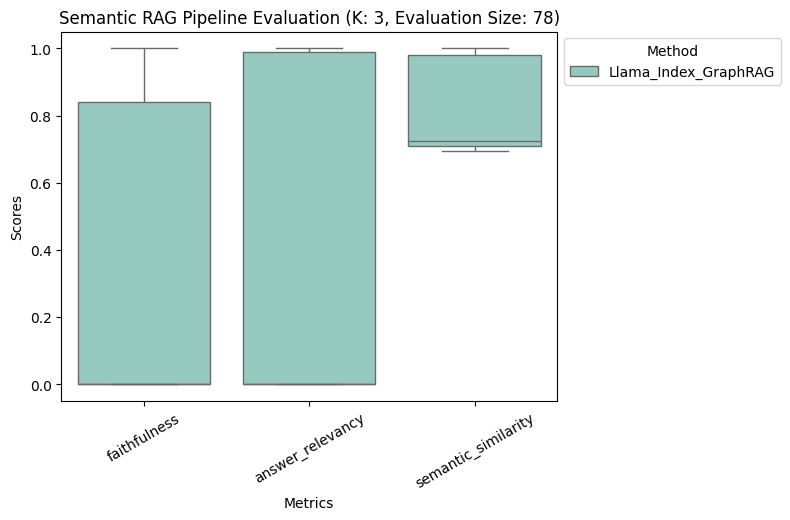

In [87]:
# boxplot for all metrics
sns.boxplot(
    x="metric",
    y="score",
    hue="method",
    hue_order=EVAL_SET,
    data=eval_df,
    palette="Set3",
    showfliers=False,
)
plt.xticks(rotation=30)
plt.title(f"Semantic RAG Pipeline Evaluation (K: {TOP_K}, Evaluation Size: {SUBSET_SIZE if SUBSET_SIZE > 0 else size})")
plt.legend(title="Method", loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.show()

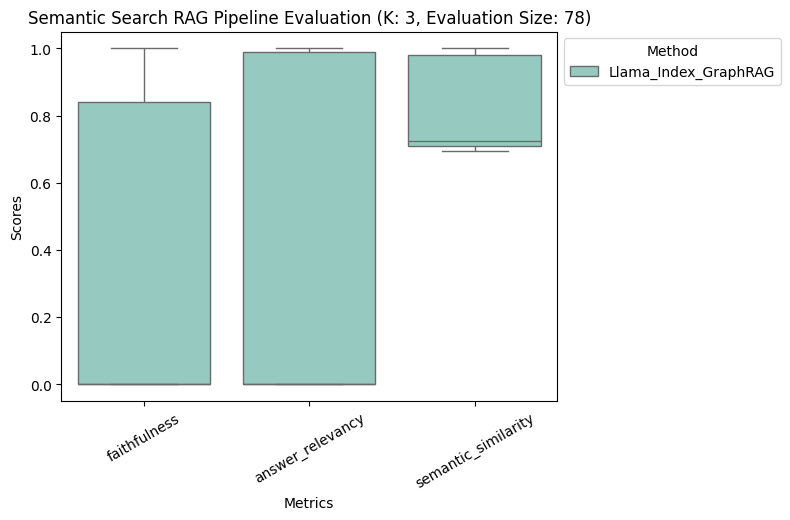

: 

In [ ]:
# boxplot for all metrics
sns.boxplot(
    x="metric",
    y="score",
    hue="method",
    hue_order=EVAL_SET,
    data=eval_df,
    palette="Set3",
    showfliers=False,
)
plt.xticks(rotation=30)
plt.title(f"Semantic Search RAG Pipeline Evaluation (K: {TOP_K}, Evaluation Size: {SUBSET_SIZE if SUBSET_SIZE > 0 else size})")
plt.legend(title="Method", loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.show()